## Imports

In [2]:
!pip install pandas==2.2.2
!pip install shap==0.46.0
!pip install xgboost==2.0.3
!pip install scikit-learn==1.4.1.post1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap
from openai import OpenAI


## Processing

In [51]:

df = pd.read_csv("/content/export.csv", low_memory=False)
print("Raw data loaded:", df.shape)
df.columns = df.columns.str.strip().str.lower()

# ensure  columns are numeric
df["trackable_value"] = pd.to_numeric(df["trackable_value"], errors="coerce")
df["checkin_month"]   = pd.to_numeric(df["checkin_month"], errors="coerce")

# drop missing identifiers from essentials
df = df.dropna(subset=["user_id", "checkin_month", "trackable_value"])
print("After dropping invalid rows:", df.shape)


# aggregate into a user to month table

monthly = (
    df.groupby(["user_id", "checkin_month"])
      .agg({
          "trackable_value": "mean",
          "country": "first",
          "sex": "first",
          "age_category": "first"
      })
      .reset_index()
      .rename(columns={"trackable_value": "symptom_mean"})
)

monthly = monthly.sort_values(["user_id", "checkin_month"]).reset_index(drop=True)
print("Aggregated user–month table:", monthly.shape)


## TEMPORAL FEATURES ##

# future month's symptoms
monthly["symptom_next"] = monthly.groupby("user_id")["symptom_mean"].shift(-1)

# month-to-month raw trend
monthly["severity_trend"] = (
    monthly.groupby("user_id")["symptom_mean"].diff().fillna(0)
)

# monthly engagement pattern
monthly["month_gap"] = monthly.groupby("user_id")["checkin_month"].diff().fillna(0)
monthly["engagement_rate"] = (
    monthly.groupby("user_id")["month_gap"]
           .transform(lambda x: (x <= 1).rolling(6, 1).mean())
           .fillna(0)
)


# lag features (to track past 3 months of progress)

for lag in [1, 2, 3]:
    monthly[f"symptom_mean_lag{lag}"] = (
        monthly.groupby("user_id")["symptom_mean"].shift(lag)
    )

# drop any rows missing lags
monthly = monthly.dropna(
    subset=["symptom_mean_lag1", "symptom_mean_lag2", "symptom_mean_lag3"]
).copy()

print("Lag features created.")


#### ENGINEERED FEATURES FOR CLASSIFIER ###

# rolling averages (3-month)
monthly["rolling_now"] = monthly.groupby("user_id")["symptom_mean"].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
monthly["rolling_prev"] = monthly.groupby("user_id")["symptom_mean"].transform(
    lambda x: x.shift(3).rolling(3, min_periods=1).mean()
)

# drop incomplete rolling windows
monthly = monthly.dropna(subset=["rolling_now", "rolling_prev"]).copy()



# 1. direct recent improvement
monthly["rolling_gap"] = monthly["rolling_prev"] - monthly["rolling_now"]

# 2. percentage improvement
monthly["pct_improvement"] = (
    (monthly["rolling_prev"] - monthly["rolling_now"]) /
    monthly["rolling_prev"].replace(0, np.nan)
).fillna(0)

# 3. most recent improvement momentum
monthly["momentum"] = monthly["symptom_mean_lag1"] - monthly["symptom_mean"]

# 4. volatility (stability of symptoms)
monthly["volatility"] = (
    monthly.groupby("user_id")["symptom_mean"]
           .transform(lambda x: x.rolling(3, min_periods=1).std())
           .fillna(0)
)

# 5. recency-weighted symptom score
monthly["recency_weighted_mean"] = (
    0.6 * monthly["symptom_mean"] +
    0.3 * monthly["symptom_mean_lag1"] +
    0.1 * monthly["symptom_mean_lag2"]
)


# baseline first-seen severity
monthly["baseline_symptom"] = monthly.groupby("user_id")["symptom_mean"].transform("first")

# sverity threshold feature
monthly["high_severity"] = (monthly["symptom_mean"] > 2).astype(int)

# simple improving indicator
monthly["improving_trend"] = (monthly["severity_trend"] < 0).astype(int)

# one-hot encoding for sex + age_category
monthly = pd.get_dummies(
    monthly,
    columns=["sex", "age_category"],
    drop_first=False
)

print("Engineered features added.")


# cleanup-remove last-month rows (no future data)

monthly = monthly.dropna(subset=["symptom_next"]).copy()
monthly = monthly.groupby("user_id").filter(lambda g: len(g) > 1)

print("Final cleaned dataset:", monthly.shape)
print("Unique patients remaining:", df["user_id"].nunique())



# quick save

monthly.to_csv("/content/depression_user_month.csv", index=False)
print("Saved processed user–month table → /content/depression_user_month.csv")

monthly.head()


Raw data loaded: (79765, 8)
After dropping invalid rows: (79765, 8)
Aggregated user–month table: (9041, 6)
Lag features created.
Engineered features added.
Final cleaned dataset: (730, 29)
Unique patients remaining: 3111
Saved processed user–month table → /content/depression_user_month.csv


,user_id,checkin_month,symptom_mean,country,symptom_next,severity_trend,month_gap,engagement_rate,symptom_mean_lag1,symptom_mean_lag2,...,high_severity,improving_trend,sex_doesnt_say,sex_female,sex_male,sex_other,age_category_adults,age_category_babies,age_category_elderly,age_category_youth
10,QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==,76,1.000000,1,1.411765,-0.181818,1.0,1.0,1.181818,1.291667,...,0,1,False,True,False,False,False,False,False,True
11,QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==,77,1.411765,1,1.238095,0.411765,1.0,1.0,1.000000,1.181818,...,0,0,False,True,False,False,False,False,False,True
12,QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==,78,1.238095,1,1.269231,-0.173669,1.0,1.0,1.411765,1.000000,...,0,1,False,True,False,False,False,False,False,True
13,QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==,79,1.269231,1,1.068966,0.031136,1.0,1.0,1.238095,1.411765,...,0,0,False,True,False,False,False,False,False,True
14,QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==,80,1.068966,1,1.107143,-0.200265,1.0,1.0,1.269231,1.238095,...,0,1,False,True,False,False,False,False,False,True


## Target Definition

In [11]:
monthly = monthly.sort_values(["user_id", "checkin_month"]).reset_index(drop=True)

# shift rolling windows forward so model predicts NEXT-MONTH change

monthly["rolling_now_future"]  = monthly.groupby("user_id")["rolling_now"].shift(-1)
monthly["rolling_prev_future"] = monthly.groupby("user_id")["rolling_prev"].shift(-1)

# binary target: 1 if NEXT-month rolling mean improves
monthly["improved_future"] = (
    (monthly["rolling_now_future"] < monthly["rolling_prev_future"]).astype(int)
)

# remove rows where future information is not available
monthly = monthly.dropna(
    subset=["rolling_now_future", "rolling_prev_future"]
).copy()

print("Target distribution:")
print(monthly["improved_future"].value_counts(normalize=True).rename("proportion"))

print("\n Preview of target columns:")
print(monthly[[
    "user_id",
    "checkin_month",
    "rolling_prev",
    "rolling_now",
    "rolling_prev_future",
    "rolling_now_future",
    "improved_future"
]].head(10))


🔹 Target distribution:
improved_future
0    0.54886
1    0.45114
Name: proportion, dtype: float64

🔹 Preview of target columns:
                            user_id  checkin_month  rolling_prev  rolling_now  \
0  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             76      1.380952     1.157828   
1  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             77      1.336310     1.197861   
2  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             78      1.284812     1.216620   
3  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             79      1.157828     1.306364   
4  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             80      1.197861     1.192097   
5  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             81      1.216620     1.148446   
6  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             82      1.306364     1.035714   
7  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             83      1.192097     0.990504   
8  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             84      1.148446     0.954789   
9  QEVuQwEA+ANQNP9YQKJ2phj0mCnyjA==             85      1.0357

## Build Feature Matrix



In [12]:
# @title
drop_cols = [
    "user_id",
    "checkin_month",
    "rolling_prev_future",
    "rolling_now_future",
    "improved_future",
    "improvement_prob",
    "improvement_pred",
    "symptom_next",
    "improved",

]

# Keep only columns that actually exist
drop_cols = [c for c in drop_cols if c in monthly.columns]

X = monthly.drop(columns=drop_cols).copy()

# encode categoricals
X = pd.get_dummies(X, drop_first=False)

# fill NA
X = X.fillna(0)

print("Final X shape:", X.shape)
print("Feature columns:", X.columns.tolist())


Final X shape: (614, 26)
Feature columns: ['symptom_mean', 'country', 'severity_trend', 'month_gap', 'engagement_rate', 'symptom_mean_lag1', 'symptom_mean_lag2', 'symptom_mean_lag3', 'rolling_now', 'rolling_prev', 'rolling_gap', 'pct_improvement', 'momentum', 'volatility', 'recency_weighted_mean', 'baseline_symptom', 'high_severity', 'improving_trend', 'sex_doesnt_say', 'sex_female', 'sex_male', 'sex_other', 'age_category_adults', 'age_category_babies', 'age_category_elderly', 'age_category_youth']


##  Classifier model

In [14]:
# CLASSIFICATION MODEL — Predict improved_future (yes/no)

from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import numpy as np

print("Running 5-fold GroupKFold classification...")

y = monthly["improved_future"].astype(int)

groups = monthly["user_id"]

print("Target defined. y shape:", y.shape)
print("Groups shape:", groups.shape)

print("Proportion improved:", y.mean())


gkf = GroupKFold(n_splits=5)

auc_scores = []
acc_scores = []
thresholds = []

# out-of-fold predictions
oof_prob = np.zeros(len(X))
oof_pred = np.zeros(len(X), dtype=int)

fold = 1
for tr_idx, va_idx in gkf.split(X, y, groups):

    Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
    ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

    # class imbalance handling
    pos_weight = (ytr == 0).sum() / max(1, (ytr == 1).sum())

    clf = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        scale_pos_weight=pos_weight,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    )

    clf.fit(Xtr, ytr)

    # predictions
    prob = clf.predict_proba(Xva)[:, 1]

    # ROC-optimized threshold - youdens j
    fpr, tpr, thr = roc_curve(yva, prob)
    j_scores = tpr - fpr
    best_thr = float(thr[np.argmax(j_scores)])

    pred = (prob >= best_thr).astype(int)

    # metrics
    auc = roc_auc_score(yva, prob)
    acc = accuracy_score(yva, pred)

    auc_scores.append(auc)
    acc_scores.append(acc)
    thresholds.append(best_thr)

    oof_prob[va_idx] = prob
    oof_pred[va_idx] = pred

    print(f"Fold {fold}:  AUC={auc:.3f}, ACC={acc:.3f}, thr*={best_thr:.3f}")
    fold += 1


print("\n=== OVERALL CLASSIFICATION PERFORMANCE ===")
print(f"Mean AUC:  {np.mean(auc_scores):.3f}  ± {np.std(auc_scores):.3f}")
print(f"Mean ACC:  {np.mean(acc_scores):.3f}  ± {np.std(acc_scores):.3f}")
print(f"Thresholds used:  {np.round(thresholds, 3)}")


monthly["improvement_prob"] = oof_prob
monthly["improvement_pred"] = oof_pred

print("Saved OOF predictions into monthly['improvement_prob']")


🚀 Running 5-fold GroupKFold classification...
Target defined. y shape: (614,)
Groups shape: (614,)
Proportion improved: 0.4511400651465798
Fold 1:  AUC=0.910, ACC=0.846, thr*=0.802
Fold 2:  AUC=0.916, ACC=0.862, thr*=0.438
Fold 3:  AUC=0.926, ACC=0.870, thr*=0.561
Fold 4:  AUC=0.922, ACC=0.854, thr*=0.355
Fold 5:  AUC=0.932, ACC=0.844, thr*=0.613

=== 🟦 OVERALL CLASSIFICATION PERFORMANCE ===
Mean AUC:  0.921  ± 0.008
Mean ACC:  0.855  ± 0.010
Thresholds used:  [0.802 0.438 0.561 0.355 0.613]
✅ Saved OOF predictions into monthly['improvement_prob']


## SHAP Value Analysis (Classifier)




🔍 Preparing SHAP analysis...


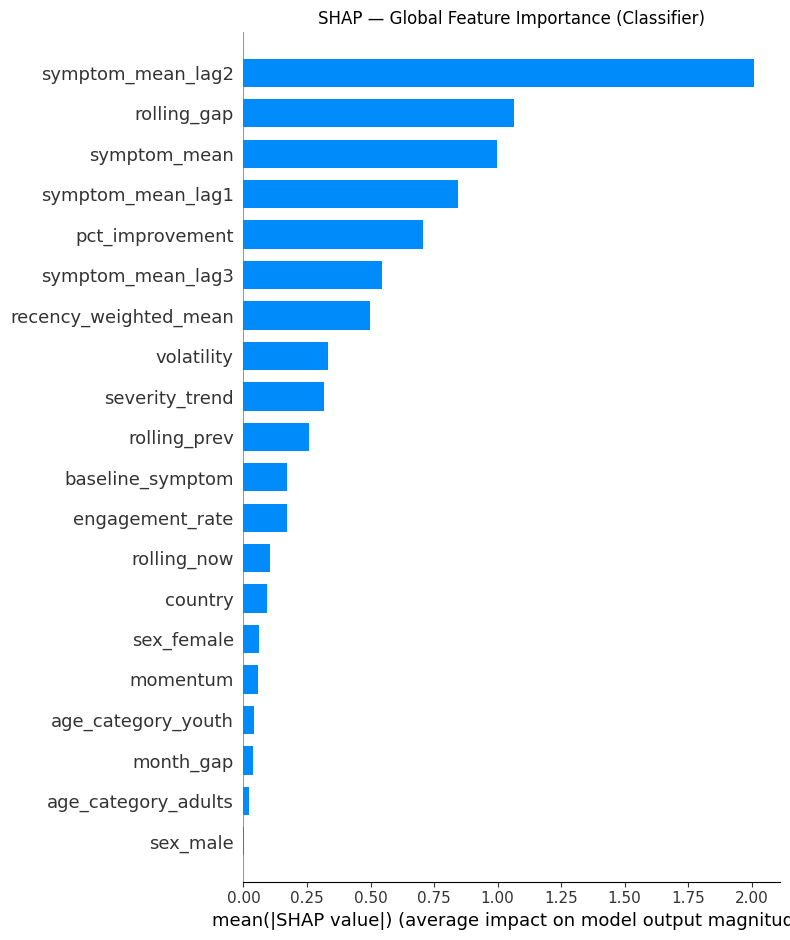

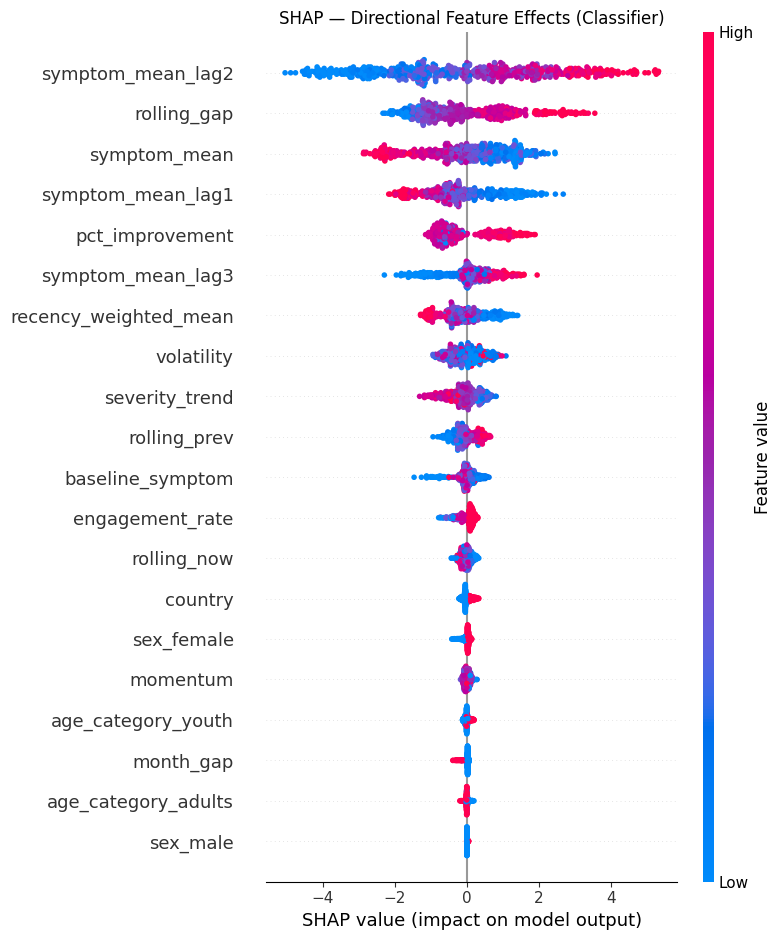

Top 3 most influential features: ['symptom_mean', 'rolling_gap', 'symptom_mean_lag2']


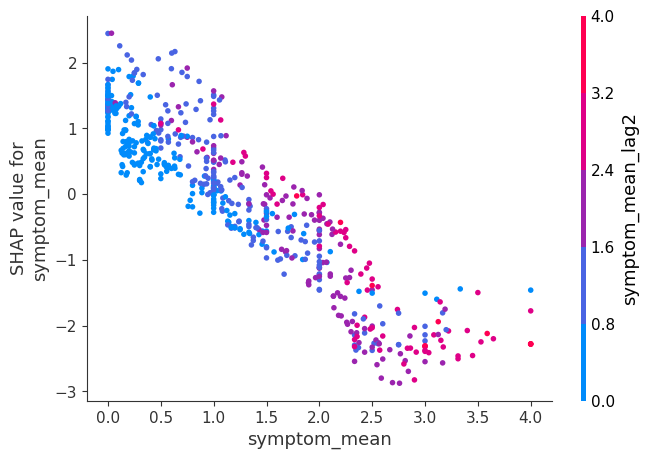

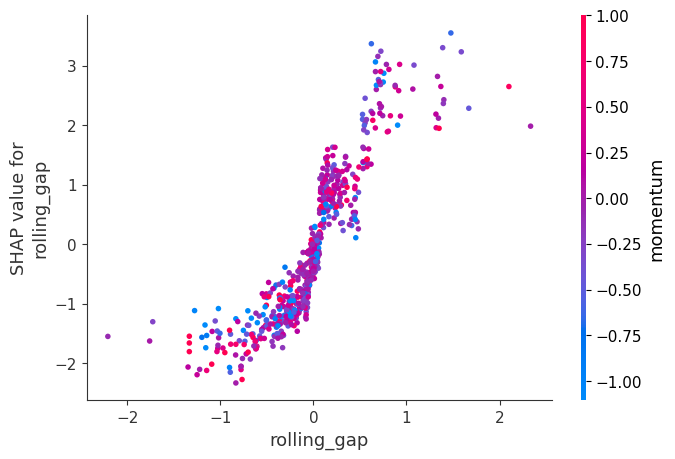

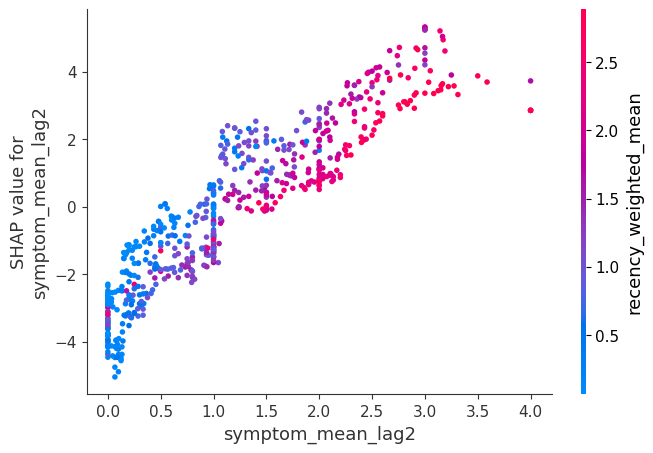

In [15]:
# SHAP ANALYSIS for CLASSIFIER MODEL
import shap
import numpy as np
import matplotlib.pyplot as plt

print("Preparing SHAP analysis...")
explainer = shap.TreeExplainer(clf)
sample_n = min(2000, len(X))
X_sample = X.sample(sample_n, random_state=42)


shap_values = explainer.shap_values(X_sample)

# global feature importance
plt.title("SHAP — Global Feature Importance (Classifier)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.show()

# feature directionality
plt.title("SHAP — Directional Feature Effects (Classifier)")
shap.summary_plot(shap_values, X_sample, show=False)
plt.show()

# top 3 dependence plots
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top3_idx = np.argsort(mean_abs_shap)[-3:]
top3_feats = X.columns[top3_idx]

print("Top 3 most influential features:", list(top3_feats))

for feat in top3_feats:
    shap.dependence_plot(feat, shap_values, X_sample)


# AI Demo Run

In [38]:
user = monthly["user_id"].sample(1).iloc[0]
sample = monthly[monthly["user_id"] == user].sample(1)
sample

,user_id,checkin_month,symptom_mean,country,symptom_next,severity_trend,month_gap,engagement_rate,symptom_mean_lag1,symptom_mean_lag2,...,sex_other,age_category_adults,age_category_babies,age_category_elderly,age_category_youth,rolling_now_future,rolling_prev_future,improved_future,improvement_prob,improvement_pred
697,QEVuQwEAvgaWzYqFh1rt7Tzn2wSvNg==,63,1.5,0,1.5,-1.5,2.0,0.666667,3.0,2.466667,...,True,False,False,False,True,2.0,2.279825,1,0.770743,1


In [40]:
prob = clf.predict_proba(sample[X.columns])[:, 1][0]
risk_level = "High" if prob > 0.6 else "Medium" if prob > 0.3 else "Low"

print(f"Predicted Improvement Probability: {prob:.2f} ({risk_level} risk)")


Predicted Improvement Probability: 0.97 (High risk)


In [41]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer(sample[X.columns])

# Get top 3 most important features for THIS patient
patient_shap = shap_values.values[0]
top_idx = np.argsort(np.abs(patient_shap))[::-1][:3]

top_features = [(X.columns[i], patient_shap[i]) for i in top_idx]
top_features


[('symptom_mean_lag2', 3.9788334),
 ('symptom_mean_lag1', -1.4219483),
 ('volatility', 0.8001771)]

In [42]:
def interpret_shap(name, val):
    direction = "increasing" if val > 0 else "decreasing"
    return f"{name.replace('_',' ')} is {direction} (SHAP={val:.2f})"

reasons = "\n".join([interpret_shap(n,v) for n,v in top_features])
print(reasons)


symptom mean lag2 is increasing (SHAP=3.98)
symptom mean lag1 is decreasing (SHAP=-1.42)
volatility is increasing (SHAP=0.80)


In [48]:
from openai import OpenAI
client = OpenAI(api_key="insert key here")

# Pick a random patient
row = sample.iloc[0]

prompt = f"""
You are a digital health assistant.

A patient has an improvement probability of {prob:.2f} ({risk_level} risk).

The top contributors to their risk profile are:
{reasons}

Write your response with:
- 2 short paragraphs (line break between them)
- Maximum 4–5 total sentences
- Supportive, empowering, motivational tone
- No mention of SHAP values, models, or probabilities
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a mental-health assistant."},
        {"role": "user", "content": prompt}
    ]
)

output = response.choices[0].message.content

# Ensure clean formatting with paragraph breaks
output = output.replace("\n", "\n\n")

print(output)


It's great to see that there has been significant awareness around your symptoms, especially with the increasing patterns you’ve been noticing. Acknowledging these changes is a crucial step towards understanding your mental health and finding the right strategies to navigate them.



Remember, every step you take towards improvement counts, and it’s important to celebrate the progress, no matter how small. Embrace the journey ahead, and know that you have the strength within you to manage these challenges and foster positive change in your life.
